In [1]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import ipywidgets as widgets
from ipywidgets import interact
%matplotlib inline

Using TensorFlow backend.


In [2]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
#     print("Lookback: {}\nDelay: {}\nStep: {}".format(lookback, delay, step))
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
#         print(samples.shape, targets.shape)
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [3]:
df = pd.read_csv('dataset.csv', delimiter=';')
df['L'] = df['L'].replace('#ZAHL!', 
    np.mean(pd.to_numeric(df['L'], errors='coerce')))
df.L = pd.to_numeric(df.L)
df.head()

,prediction,Open,High,Low,Close,Volume,TP,R,V,L,...,H1,H2,H3,H4,H5,I1,I2,I3,I4,I5
0,19.200001,25.000000,25.920000,20.270000,21.959999,8218800,22.716666,-0.121212,0.028021,3.050469,...,0.156448,156.447836,-0.156448,156447.83630,-156447.83630,0.990233,990.232516,-0.990233,990232.5162,-990232.5162
1,16.110001,23.000000,23.100000,18.709999,19.200001,5139800,20.336667,-0.104769,0.014692,3.473337,...,0.252048,252.047685,-0.252048,252047.68460,-252047.68460,0.456262,456.261502,-0.456262,456261.5017,-456261.5017
2,15.800000,20.000000,20.000000,15.830000,16.110001,6866900,17.313334,-0.148664,0.010977,2.498515,...,0.711970,711.969763,-0.711970,711969.76340,-711969.76340,0.351666,351.665749,-0.351666,351665.7485,-351665.7485
3,17.459999,16.400000,16.629999,14.980000,15.800000,6921700,15.803333,-0.087216,0.022101,3.467955,...,0.012320,12.320090,-0.012320,12320.09031,-12320.09031,0.878700,878.699784,-0.878700,878699.7836,-878699.7836
4,17.400000,16.139999,17.520000,15.570000,17.459999,7711400,16.850000,0.066231,0.007607,4.302065,...,0.431436,431.435976,-0.431436,431435.97600,-431435.97600,0.801785,801.784522,-0.801785,801784.5223,-801784.5223


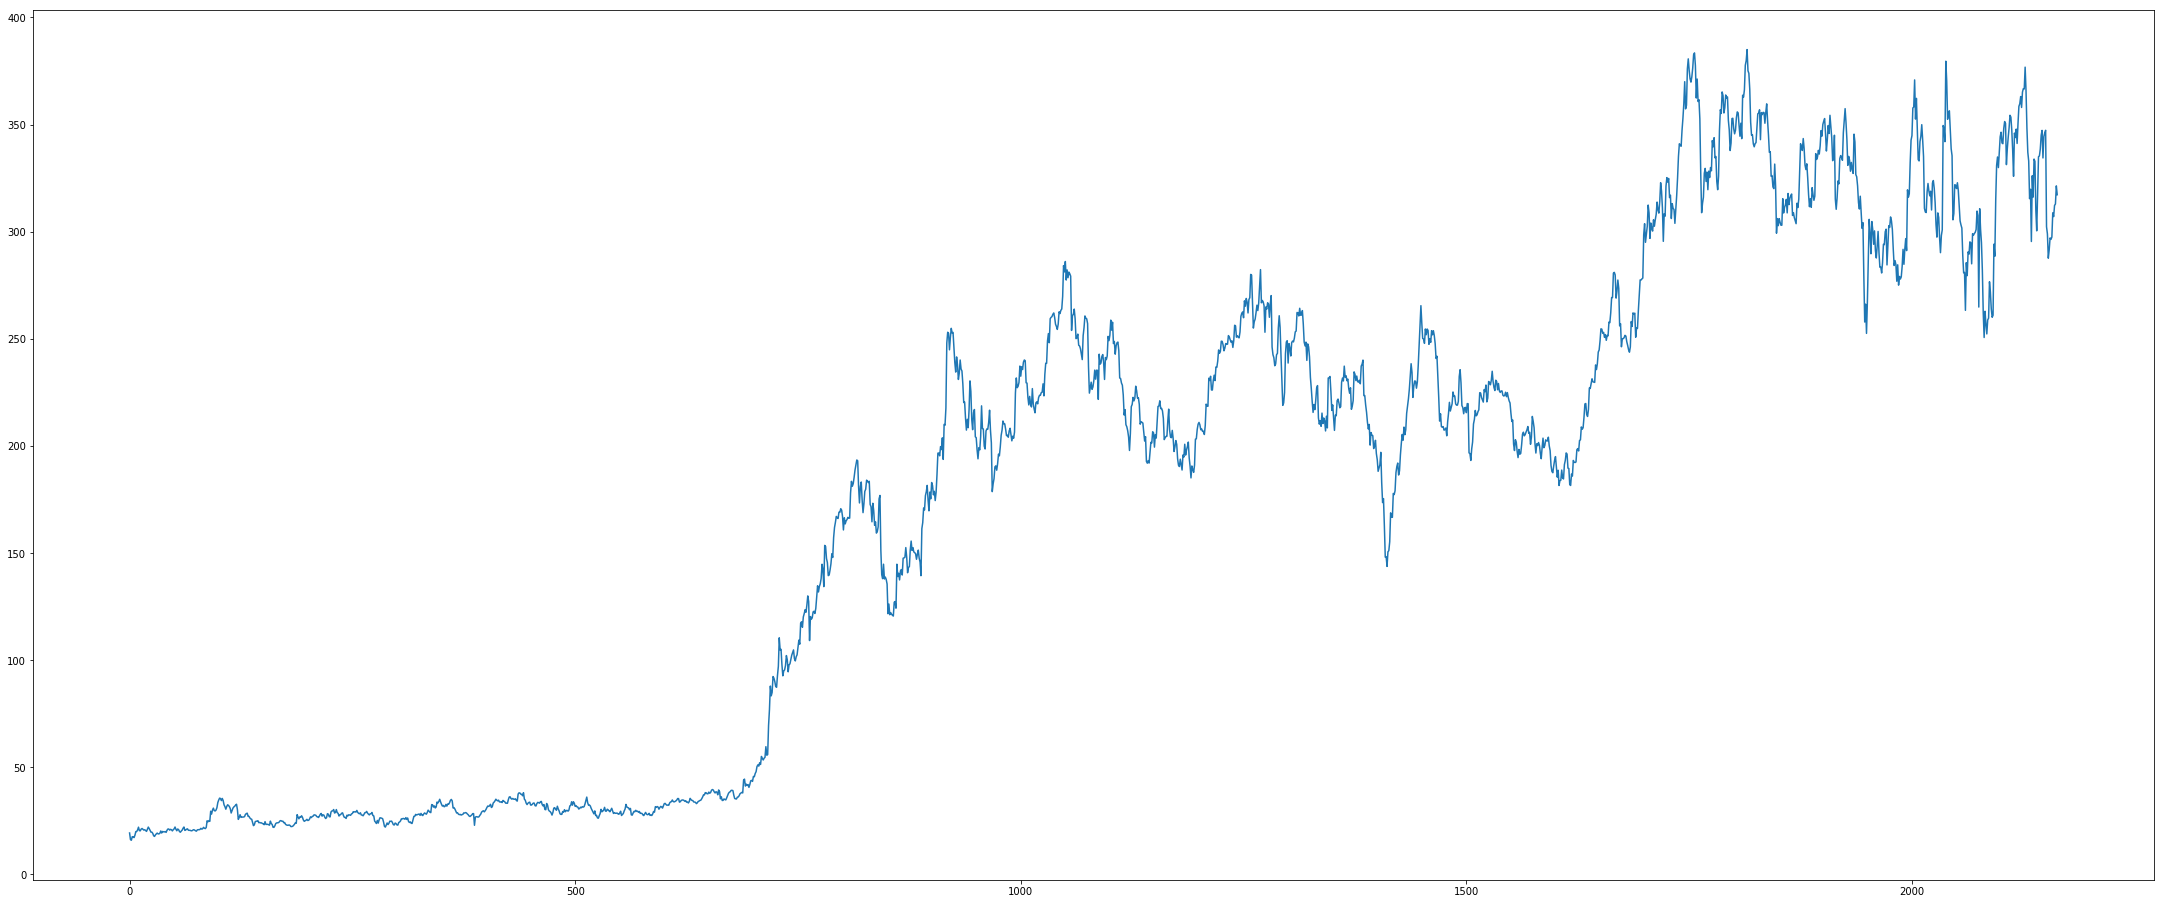

In [4]:
pyplot.figure(figsize=(38,16))
df['prediction'].plot()

In [5]:
col_names = df.columns
p = []
for c in col_names[1:]:
    p.append(widgets.Checkbox(
    value=True,
    description=c,
    disabled=False
))
#Select the columns which need to go into the model
widgets.VBox(children=p,
        layout=widgets.Layout(
            width='100%',
            grid_template_columns='auto auto auto',
            grid_gap='auto auto')
       )

In [6]:
train_count = 1200 #using 1500 rows for training
val_count = 450 #values from train_count+1 to train_count + val_count will be included in the validation data
selected = [x.description for x in p if x.value]
selected.insert(0, col_names[0]) #putting the prediction variable at the start
df = df[selected]
df.head()

,prediction,Open,High,Low,Close,Volume,TP,R,V,L,...,H1,H2,H3,H4,H5,I1,I2,I3,I4,I5
0,19.200001,25.000000,25.920000,20.270000,21.959999,8218800,22.716666,-0.121212,0.028021,3.050469,...,0.156448,156.447836,-0.156448,156447.83630,-156447.83630,0.990233,990.232516,-0.990233,990232.5162,-990232.5162
1,16.110001,23.000000,23.100000,18.709999,19.200001,5139800,20.336667,-0.104769,0.014692,3.473337,...,0.252048,252.047685,-0.252048,252047.68460,-252047.68460,0.456262,456.261502,-0.456262,456261.5017,-456261.5017
2,15.800000,20.000000,20.000000,15.830000,16.110001,6866900,17.313334,-0.148664,0.010977,2.498515,...,0.711970,711.969763,-0.711970,711969.76340,-711969.76340,0.351666,351.665749,-0.351666,351665.7485,-351665.7485
3,17.459999,16.400000,16.629999,14.980000,15.800000,6921700,15.803333,-0.087216,0.022101,3.467955,...,0.012320,12.320090,-0.012320,12320.09031,-12320.09031,0.878700,878.699784,-0.878700,878699.7836,-878699.7836
4,17.400000,16.139999,17.520000,15.570000,17.459999,7711400,16.850000,0.066231,0.007607,4.302065,...,0.431436,431.435976,-0.431436,431435.97600,-431435.97600,0.801785,801.784522,-0.801785,801784.5223,-801784.5223


In [7]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
float_data = df.values
scaled_train = scaler.fit_transform(float_data[:train_count])
scaled_val = scaler.transform(float_data[train_count:train_count+val_count])
scaled_test = scaler.transform(float_data[train_count+val_count:])

scaled_data = np.vstack((scaled_train, scaled_val, scaled_test))

pd.DataFrame(data=scaled_data, columns=df.columns).head()

,prediction,Open,High,Low,Close,Volume,TP,R,V,L,...,H1,H2,H3,H4,H5,I1,I2,I3,I4,I5
0,-0.974837,-0.934740,-0.932385,-0.960139,-0.954411,-0.562683,-0.948819,-0.855296,0.052421,1.0,...,-0.687256,-0.687256,0.687256,-0.687256,0.687256,0.982693,0.982693,-0.982693,0.982693,-0.982693
1,-0.997706,-0.949472,-0.952909,-0.971894,-0.974837,-0.728911,-0.966438,-0.768622,-0.448176,1.0,...,-0.495804,-0.495804,0.495804,-0.495804,0.495804,-0.087056,-0.087056,0.087056,-0.087056,0.087056
2,-1.000000,-0.971569,-0.975472,-0.993595,-0.997706,-0.635669,-0.988821,-1.000000,-0.587738,1.0,...,0.425253,0.425253,-0.425253,0.425253,-0.425253,-0.296602,-0.296602,0.296602,-0.296602,0.296602
3,-0.987715,-0.998085,-1.000000,-1.000000,-1.000000,-0.632710,-1.000000,-0.676098,-0.169918,1.0,...,-0.975891,-0.975891,0.975891,-0.975891,0.975891,0.759250,0.759250,-0.759250,0.759250,-0.759250
4,-0.988159,-1.000000,-0.993522,-0.995554,-0.987715,-0.590076,-0.992251,0.132742,-0.714306,1.0,...,-0.136554,-0.136554,0.136554,-0.136554,0.136554,0.605159,0.605159,-0.605159,0.605159,-0.605159


In [22]:
lookback = 14
step = 2
delay = 1
batch_size = 64

train_gen = generator(scaled_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=train_count,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)
val_gen = generator(scaled_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=train_count+1,
                    max_index=train_count+val_count,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(scaled_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=train_count+val_count+1,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

val_steps = (train_count+val_count - train_count+1 - lookback)
test_steps = (len(float_data) - train_count+val_count+1 - lookback)

In [23]:
layers = widgets.BoundedIntText(
    value=7,
    min=4,
    max=9999,
    step=1,
    description='Layers:',
    disabled=False
)
layers

BoundedIntText(value=7, description='Layers:', max=9999, min=4)

In [24]:
neurons = []
style = {'description_width': 'initial'}
for l in range(layers.value):
    neurons.append(
        widgets.BoundedIntText(
        value=7,
        min=1,
        max=9999,
        step=1,
        description='Neurons in Layer {}:'.format(l+1),
        disabled=False,
        style=style
    )
)
#Widgets for each neuron
widgets.GridBox(children=neurons,
        layout=widgets.Layout(
            width='100%',
            grid_template_columns='auto',
            grid_gap='auto auto')
       )

GridBox(children=(BoundedIntText(value=7, description='Neurons in Layer 1:', max=9999, min=1, style=Descriptio…

In [25]:
# design network
model = Sequential()
for i in range(layers.value):
    if i == 0:
        print("first", i)
        model.add(LSTM(neurons[i].value, input_shape=(None, float_data.shape[-1]), return_sequences=True, dropout=0.2))
    elif i < layers.value-1:
        print("middle", i)
        model.add(LSTM(neurons[i].value, return_sequences=True, dropout=0.2))
    else:
        print("last", i)
        model.add(LSTM(neurons[i].value, return_sequences=False, dropout=0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='rmsprop')
model.summary()

first 0
middle 1
middle 2
middle 3
last 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 2)           480       
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 1)           16        
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 2)           32        
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 1)           16        
_________________________________________________________________
lstm_9 (LSTM)                (None, 2)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 579
Trainable params: 579
Non-trainable params: 0
____________________________________

In [26]:
filepath = 'best.weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

# fit network
history = model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=50,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/50
500/500 [==============================] - 13s 26ms/step - loss: 0.4295 - val_loss: 0.3656
Epoch 2/50
500/500 [==============================] - 10s 19ms/step - loss: 0.2544 - val_loss: 0.1958
Epoch 3/50
500/500 [==============================] - 9s 19ms/step - loss: 0.2082 - val_loss: 0.1998
Epoch 4/50
500/500 [==============================] - 9s 18ms/step - loss: 0.1895 - val_loss: 0.2068
Epoch 5/50
500/500 [==============================] - 10s 19ms/step - loss: 0.1827 - val_loss: 0.1978
Epoch 6/50
500/500 [==============================] - 9s 18ms/step - loss: 0.1771 - val_loss: 0.1950
Epoch 7/50
500/500 [==============================] - 9s 19ms/step - loss: 0.1756 - val_loss: 0.1894
Epoch 8/50
500/500 [==============================] - 9s 17ms/step - loss: 0.1728 - val_loss: 0.1873
Epoch 9/50
500/500 [==============================] - 9s 18ms/step - loss: 0.1652 - val_loss: 0.1858
Epoch 10/50
500/500 [==============================] - 9s 19ms/step - loss: 0.1586 - val

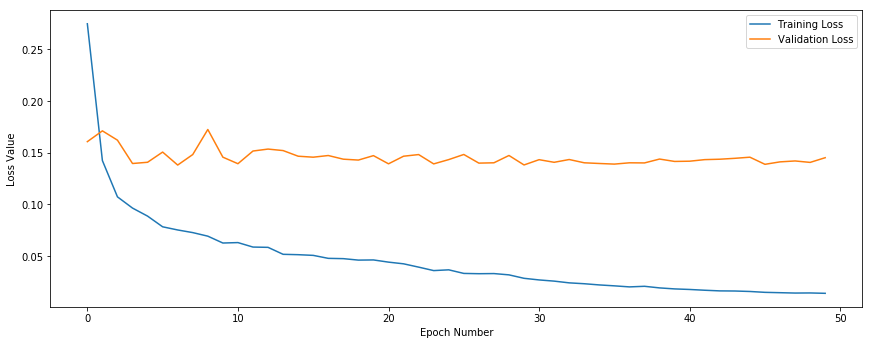

In [13]:
pyplot.figure(figsize=(32, 12))
pyplot.subplot(221)
pyplot.plot(history.history['loss'], label="Training Loss")
pyplot.plot(history.history['val_loss'], label="Validation Loss")
pyplot.ylabel("Loss Value")
pyplot.xlabel("Epoch Number")
pyplot.legend()

#     pyplot.subplot(222)
pyplot.show()

In [14]:
# # trainP = model.predict(train_X)
# val_gen.close()
# test_gen.close()
# train_gen.close()

In [20]:
steps = 15
valP = model.predict_generator(val_gen, steps=steps)
val_y = np.array([val_gen.send(x)[1] for x in range(steps)])
val_y = val_y.flatten()
valP.shape, len(val_y)

((480, 1), 480)

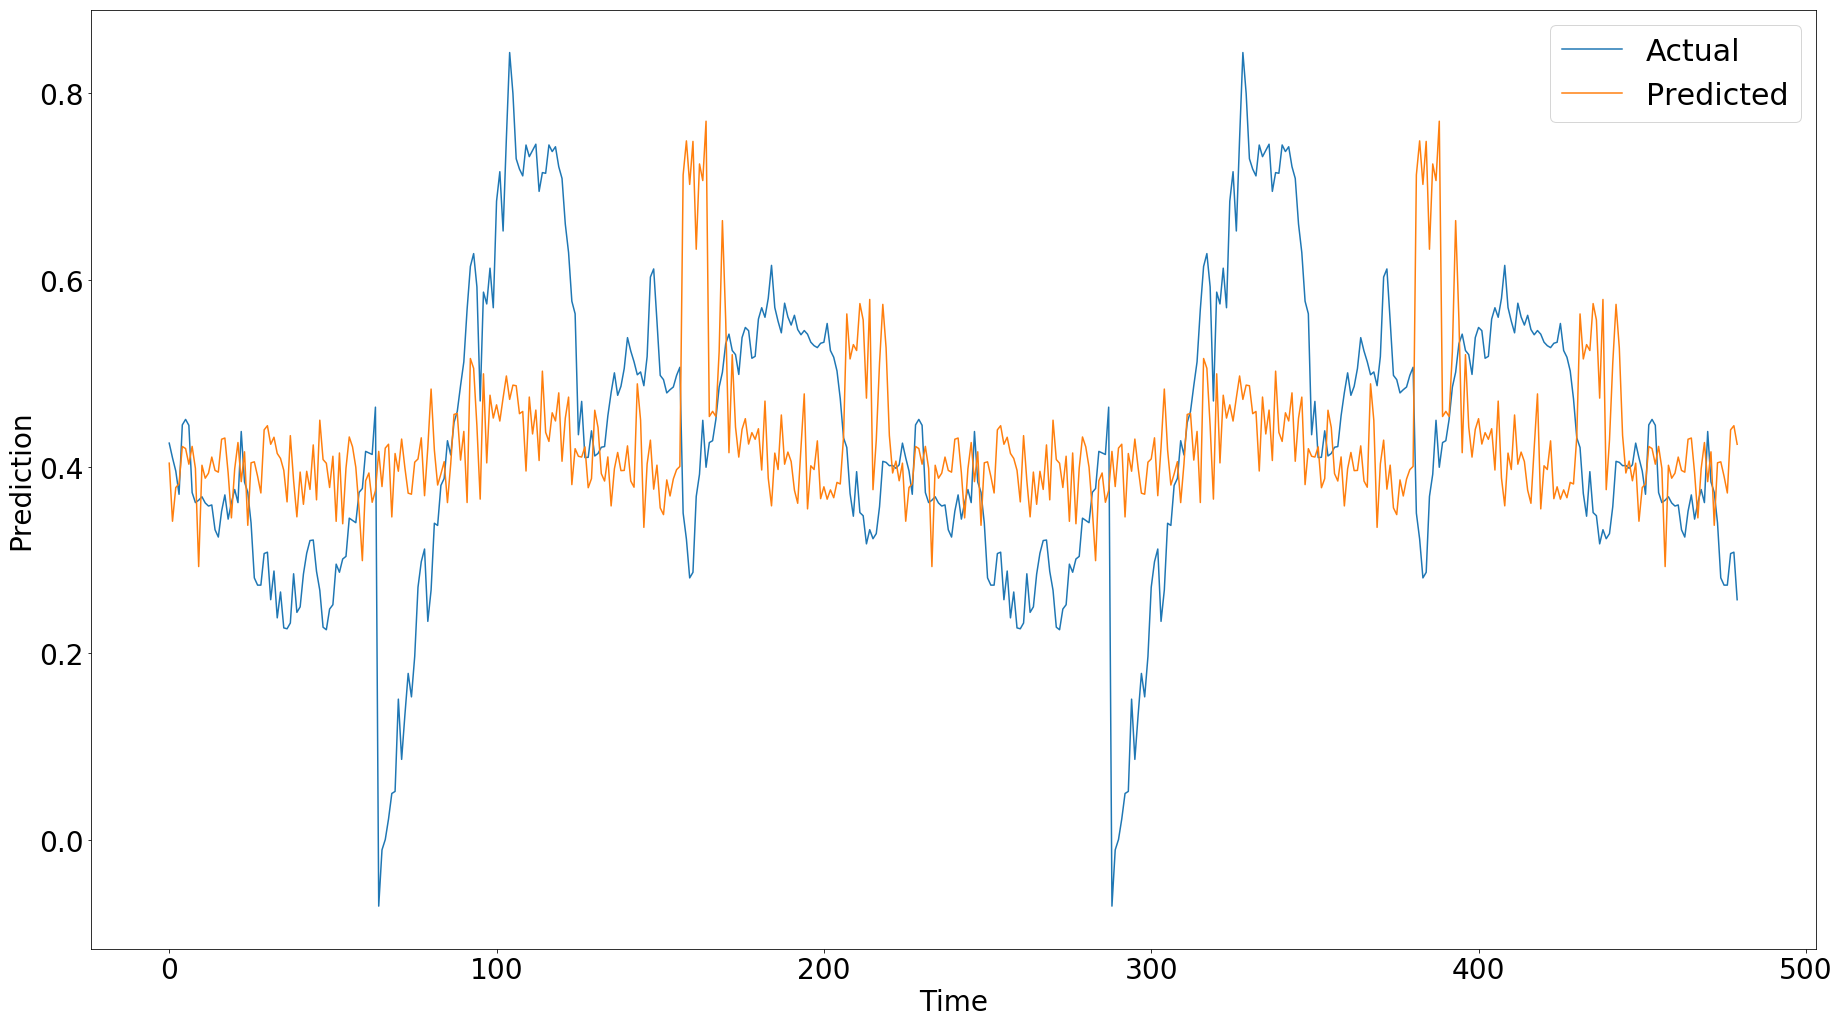

In [21]:
pyplot.figure(figsize=(68, 38))
pyplot.subplot(221)
pyplot.rc('xtick', labelsize=28)    # fontsize of the tick labels
pyplot.rc('ytick', labelsize=28)    # fontsize of the tick labels
pyplot.rc('legend', fontsize=30)    # legend fontsize
pyplot.rc('axes', labelsize=28)    # fontsize of the x and y labels
pyplot.plot(val_y, label="Actual")
pyplot.plot(valP, label="Predicted")
pyplot.ylabel("Prediction")
pyplot.xlabel("Time")
pyplot.legend()

#     pyplot.subplot(222)
pyplot.show()